In [1]:
import importlib
import random
import pickle
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.dates import date2num
from scipy import stats
from statsmodels.tsa.stattools import adfuller

import utils
importlib.reload(utils)

from utils import (
    logging,
    TARGET_PROTEIN,
    SAMPLE_END_DATE,
    COMBO_MIN_NUM,
    MUTATION_PER_SEQ_FILE,
    FIXATION_LINKAGE_FILE,
    RECOMMENDED_MUTATIONS_FILE,
    FUTURE_COMBO_MISSED_FILE,
    FUTURE_COMBO_CAPTURED_FILE,
)

import utils.miscellaneous
importlib.reload(utils.miscellaneous)

from utils.miscellaneous import remove_same_site_combo

combo_min_num = COMBO_MIN_NUM
score_threshold = 0


/home/chengyang/miniconda3/envs/fixynergy/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
logging.info("Load data...")

df: pd.DataFrame = pd.read_feather(MUTATION_PER_SEQ_FILE)
df["Date"] = pd.to_datetime(df["Date"])

df = df[df["Mutation"].str.contains(TARGET_PROTEIN)]
df = df[~df["Mutation"].str.contains("stop")]
df = df[~df["Mutation"].str.contains("ins")]
df["AA"] = df["Mutation"].str.split("_").str[1].str[1:]

future_df = df[df["Date"] >= SAMPLE_END_DATE]
df = df[df["Date"] < SAMPLE_END_DATE]

fixation_linkage = pd.read_csv(FIXATION_LINKAGE_FILE)
aa_combo: pd.DataFrame = pd.read_feather(RECOMMENDED_MUTATIONS_FILE)
aa_combo = aa_combo[aa_combo["Accession"].str.contains(TARGET_PROTEIN)]


In [3]:
known_muts = set(df["AA"].unique())
all_possible_mut_combo = set(
    (frozenset(i) for i in combinations(known_muts, combo_min_num))
)
all_possible_mut_combo = remove_same_site_combo(all_possible_mut_combo)

len(all_possible_mut_combo)


4447099

In [4]:
existing_combo = []

ac_group: pd.DataFrame
for ac, ac_group in df.groupby("Accession", sort=False):
    if len(ac_group.index) >= combo_min_num:
        existing_combo.extend(
            (frozenset(i)
             for i in combinations(ac_group["AA"].values, combo_min_num))
        )

existing_combo = set(existing_combo)
assert len(existing_combo.difference(all_possible_mut_combo)) == 0

len(existing_combo)


13978

In [5]:
recommended_combo = []

mut_group: pd.DataFrame
for mut, mut_group in aa_combo.groupby("Accession", sort=False):
    mut = mut.split("_")[1][1:]
    mut_group = mut_group[mut_group["Score"] > score_threshold]
    mutated = (mut_group["Pos"].astype(str) + mut_group["AA"]).values
    recommended_combo.extend(
        (frozenset((mut, i)) for i in mutated if i != mut)
    )

recommended_combo = set(recommended_combo).difference(existing_combo)
len(recommended_combo)


3179832

In [6]:
unreached_combo = all_possible_mut_combo.difference(existing_combo)
possible_combo = recommended_combo.intersection(all_possible_mut_combo)
random_combo = set(random.sample(
    list(unreached_combo),
    k=len(possible_combo)
))


In [7]:
future_combo = {}
future_combo_stat = []
# future_combo_dated = {} # For combo counts
existing_future_combo = set()
ac_group: pd.DataFrame
c_date_group: pd.DataFrame
for c_date, c_date_group in future_df.groupby("Date", sort=False):

    logging.info(f"Future hits stat: {c_date}")

    c_date_combo = []
    c_date_group = c_date_group[c_date_group["AA"] != ""]

    c_date_muts = set(c_date_group["AA"].values)
    hit_muts = c_date_muts.intersection(known_muts)

    for ac, ac_group in c_date_group.groupby("Accession", sort=False):
        if len(ac_group.index) >= combo_min_num:
            c_date_combo.extend(
                (frozenset(i)
                 for i in combinations(ac_group["AA"].values, combo_min_num))
            )
    
    # c_date_combo = Counter(c_date_combo)
    # future_combo_dated[c_date] = c_date_combo
    # c_date_combo = set(c_date_combo.keys())
    c_date_combo = set(c_date_combo)

    c_date_combo = c_date_combo.difference(existing_combo)
    c_date_combo = c_date_combo.difference(existing_future_combo)

    hit_combo = c_date_combo.intersection(unreached_combo)
    hit_combo_recom = c_date_combo.intersection(possible_combo)
    hit_combo_random = c_date_combo.intersection(random_combo)
    future_combo_stat.append({
        "Date": c_date,
        "Target": len(c_date_combo),
        "Hit": len(hit_combo),
        "Hit_recom": len(hit_combo_recom),
        "Hit_random": len(hit_combo_random),
        "Target_muts": len(c_date_muts),
        "Hit_muts": len(hit_muts)
    })
    future_combo[c_date] = c_date_combo
    existing_future_combo = existing_future_combo.union(c_date_combo)

future_combo_stat = pd.DataFrame(future_combo_stat)


In [8]:
future_all_combo = []
for c_date_combo in future_combo.values():
    future_all_combo.extend(c_date_combo)

future_all_combo = set(future_all_combo)
future_possible_combo = unreached_combo.intersection(future_all_combo)


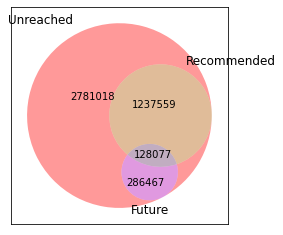

In [9]:
venn3(
    [unreached_combo, possible_combo, future_possible_combo],
    ("Unreached", "Recommended", "Future")
)
plt.gca().set_facecolor('white')
plt.gca().set_axis_on()
plt.savefig("plots/venn_graph.pdf")


In [12]:
with open(FUTURE_COMBO_MISSED_FILE, "wb") as f:
    pickle.dump(future_possible_combo.difference(possible_combo), f)

with open(FUTURE_COMBO_CAPTURED_FILE, "wb") as f:
    pickle.dump(future_possible_combo.intersection(possible_combo), f)


In [13]:
future_combo_stat_dated = future_combo_stat[future_combo_stat["Hit"] > 10].set_index("Date").sort_index()

ma_days = 30

future_combo_stat_dated["Hit_avg"] = future_combo_stat_dated["Hit"].rolling(ma_days).mean()
future_combo_stat_dated["Hit_recom_avg"] = future_combo_stat_dated["Hit_recom"].rolling(ma_days).mean()
future_combo_stat_dated["Hit_random_avg"] = future_combo_stat_dated["Hit_random"].rolling(ma_days).mean()
future_combo_stat_dated["Target_avg"] = future_combo_stat_dated["Target"].rolling(ma_days).mean()

future_combo_stat_dated["Hit_muts_avg"] = future_combo_stat_dated["Hit_muts"].rolling(ma_days).mean()
future_combo_stat_dated["Target_muts_avg"] = future_combo_stat_dated["Target_muts"].rolling(ma_days).mean()

future_combo_stat_ma = future_combo_stat_dated.dropna()

muts_p=0.016578083064218405
combo_p=0.06662712666056522


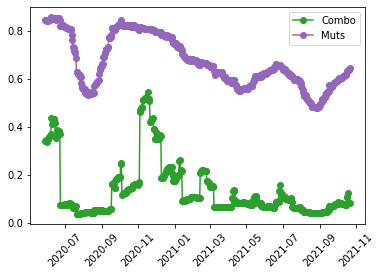

In [14]:
muts_p = adfuller(future_combo_stat_ma["Hit_muts_avg"] / future_combo_stat_ma["Target_muts_avg"])[1]
combo_p = adfuller(future_combo_stat_ma["Hit_avg"] / future_combo_stat_ma["Target_avg"])[1]

print(f"{muts_p=}\n{combo_p=}")

plt.plot_date(
    future_combo_stat_ma.index,
    future_combo_stat_ma["Hit_avg"] / future_combo_stat_ma["Target_avg"],
    linestyle="-",
    label="Combo",
    color="tab:green"
)
plt.plot_date(
    future_combo_stat_ma.index,
    future_combo_stat_ma["Hit_muts_avg"] / future_combo_stat_ma["Target_muts_avg"],
    linestyle="-",
    label="Muts",
    color="tab:purple"
)
plt.xticks(rotation=45)
plt.legend()

plt.savefig("plots/hit_combo.pdf", bbox_inches="tight")

random_p=1.5628381887598945e-11
recom_p=0.22240776257301198


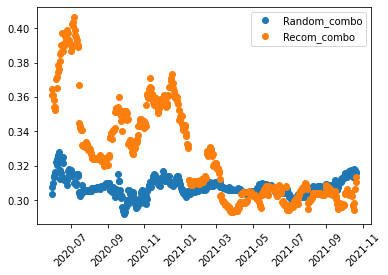

In [15]:
random_p = adfuller(future_combo_stat_dated["Hit_random"] / future_combo_stat_dated["Hit"])[1]
recom_p = adfuller(future_combo_stat_dated["Hit_recom"] / future_combo_stat_dated["Hit"])[1]

print(f"{random_p=}\n{recom_p=}")

plt.plot_date(
    future_combo_stat_ma.index,
    future_combo_stat_ma["Hit_random_avg"] / future_combo_stat_ma["Hit_avg"],
    label="Random_combo"
)
plt.plot_date(
    future_combo_stat_ma.index,
    future_combo_stat_ma["Hit_recom_avg"] / future_combo_stat_ma["Hit_avg"],
    label="Recom_combo"
)
plt.xticks(rotation=45)
plt.legend()
# plt.title(f"Random ADF p value: {random_p}\nRecom ADF p value: {recom_p}")
plt.savefig("plots/stationarity.pdf", bbox_inches="tight")


In [16]:
all_random_hit = []
hit_distribution = []

for i in range(500):

    logging.info(f"Random hits stat {i}")

    random_combo = random.sample(
        list(unreached_combo),
        k=len(possible_combo)
    )
    random_hit_combo = set(random_combo).intersection(future_all_combo)
    hit_distribution.append(len(random_hit_combo))

    random_hit = []
    for c_date, c_date_combo in future_combo.items():
        hit_combo_random = c_date_combo.intersection(random_hit_combo)
        random_hit.append({
            "Date": c_date,
            "Hit_random_2": len(hit_combo_random)
        })
    random_hit = pd.DataFrame.from_records(random_hit)
    all_random_hit.append(random_hit)


In [17]:
random_adf_p = []

for random_hit in all_random_hit:
    random_hit = pd.merge(random_hit, future_combo_stat,
                          left_on="Date", right_on="Date")
    random_hit = random_hit[random_hit["Hit"] > 10].set_index("Date").sort_index()
    random_adf_p.append(adfuller(random_hit["Hit_random_2"] / random_hit["Hit"])[1])

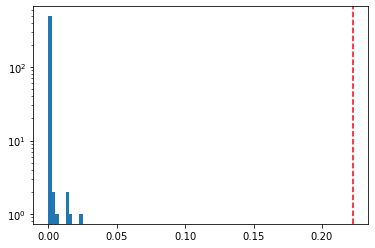

In [18]:
plt.hist(random_adf_p)
plt.yscale('log')
plt.axvline(x=recom_p, color="red", linestyle="--")
plt.savefig("plots/adf_p_value_comparison.pdf", bbox_inches="tight")


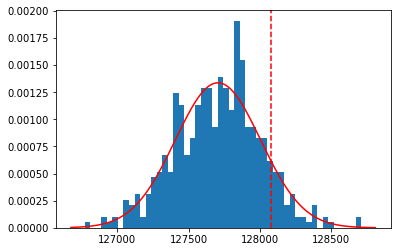

In [19]:
mu, std = stats.norm.fit(hit_distribution)

plt.hist(hit_distribution, bins=50, density=True)
xmin, xmax = plt.xlim()
x_axis = np.linspace(xmin, xmax, 1000)
norm_pdf = stats.norm.pdf(x_axis, mu, std)
plt.plot(x_axis, norm_pdf, color="red")

plt.axvline(x=future_combo_stat["Hit_recom"].sum(), color="red", linestyle="--")

plt.savefig("plots/recom_vs_random.pdf", bbox_inches="tight")


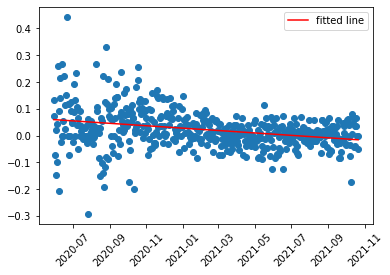

In [20]:
recom_random_diff = (future_combo_stat_ma["Hit_recom"] - future_combo_stat_ma["Hit_random"]) / future_combo_stat_ma["Hit"]
slope, intercept, r, p, se = stats.linregress(date2num(future_combo_stat_ma.index.values), recom_random_diff)

plt.plot_date(
    future_combo_stat_ma.index,
    recom_random_diff
)
plt.plot(
    future_combo_stat_ma.index.values,
    intercept + slope*date2num(future_combo_stat_ma.index.values),
    'r',
    label='fitted line'
)
plt.xticks(rotation=45)
plt.legend()


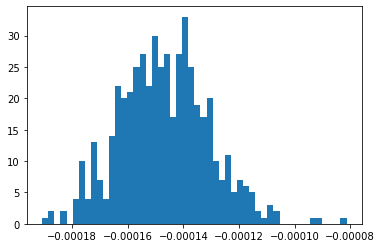

In [21]:
recom_random_diff_slope = []

for random_hit in all_random_hit:
    random_hit = pd.merge(random_hit, future_combo_stat,
                          left_on="Date", right_on="Date")
    random_hit = random_hit[random_hit["Hit"]
                            > 10].set_index("Date").sort_index()
    recom_random_diff = (
        random_hit["Hit_recom"] - random_hit["Hit_random_2"]) / random_hit["Hit"]
    slope, intercept, r, p, se = stats.linregress(
        date2num(random_hit.index.values), recom_random_diff)
    recom_random_diff_slope.append(slope)

plt.hist(recom_random_diff_slope, bins=50)
plt.savefig("plots/diff_slope.pdf", bbox_inches="tight")
